In [1]:
import gym, gym_futbol_v1
%matplotlib inline
from gym_futbol_v1.envs import Side
from utils import notebook_render_simple, notebook_render_mlp, notebook_render_lstm, MultiAgentWrapper, MultiAgentTrain
from training import ppo2_mlp_policy_train, ppo2_mlp_lstm_policy_train, ppo2_mlp_multi_agent_train
from stable_baselines import PPO2

Loading chipmunk for Darwin (64bit) [/Users/jim/Library/Python/3.7/lib/python/site-packages/pymunk/libchipmunk.dylib]
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Test Env

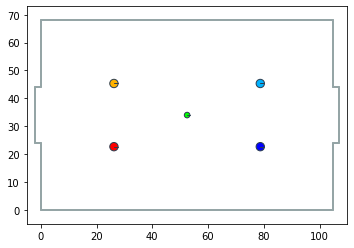

[[52.5        34.          0.          0.        ]
 [26.25       22.66666667  0.          0.        ]
 [26.25       45.33333333  0.          0.        ]
 [78.75       22.66666667  0.          0.        ]
 [78.75       45.33333333  0.          0.        ]]


In [2]:
env = gym.make("futbol-v1")
env.render()
print(env.reset().reshape((-1,4)))

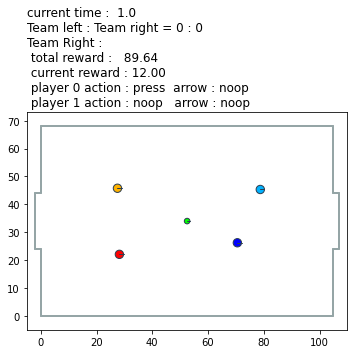

In [3]:
total_reward = notebook_render_simple(env, length=10, random=False, action=[0,3,0,0], side=Side.right)

# PPO2 with Mlp Policy

In [ ]:
model, save_dir = ppo2_mlp_policy_train(time_step=10**4, verbose=0)

In [ ]:
best_model = PPO2.load(save_dir + "/best_model")

In [ ]:
total_reward = notebook_render_mlp('futbol-v1', best_model)

# PPO2 with MlpLstm Policy

In [ ]:
model, save_dir = ppo2_mlp_lstm_policy_train(time_step=10**4, verbose=0)

In [ ]:
model.learn(total_timesteps=10**5)

In [ ]:
total_reward = notebook_render_lstm('futbol-v1', model)

# Multi Agent with PPO2

In [ ]:
model_left, model_right, save_dir = ppo2_mlp_multi_agent_train(time_step=10**4, num_turn=2, verbose=0)

In [ ]:
env_right = MultiAgentWrapper(gym.make('futbol-v1'), Side.right)
env_right.set_agent(model_left, Side.left)
reward = notebook_render_mlp(env_right, model_right, length=300, side=Side.right)

In [ ]:
env_left = MultiAgentWrapper(gym.make('futbol-v1'), Side.left)
env_left.set_agent(model_right, Side.right)
reward = notebook_render_mlp(env_left, model_left, length=300, side=Side.left)

## Multi Agent with the defined class

In [4]:
multi_agent = MultiAgentTrain()

In [9]:
multi_agent.get_info()

Training Turn : 5
Total Time Step : 100000
Model Left Time Step : 50000
Model Right Time Step : 50000
Model Save Directory : ./training/logs/ppo2-mlp-multi-agent-1592222977
Model Log Directory : ./training/tmp/ppo2-mlp-multi-agent-1592222977
Verbose : 0


In [ ]:
multi_agent.notebook_render_left()

In [8]:
multi_agent.train(num_turn=3, time_step=10 ** 4, verbose=0, save=True, save_interval=2)

left__model saved to ./training/logs/ppo2-mlp-multi-agent-1592222977/ppo2-mlp-2-left.zip
right_model saved to ./training/logs/ppo2-mlp-multi-agent-1592222977/ppo2-mlp-2-right.zip
left__model saved to ./training/logs/ppo2-mlp-multi-agent-1592222977/ppo2-mlp-4-left.zip
right_model saved to ./training/logs/ppo2-mlp-multi-agent-1592222977/ppo2-mlp-4-right.zip


In [ ]:
multi_agent.notebook_render_right()

In [ ]:
multi_agent.env_right.team_right_agent # should be BaseAgent as the action is overwritten by the model left in render fun

In [ ]:
multi_agent.env_right.team_left_agent

In [10]:
multi_agent.save_models()